<a href="https://colab.research.google.com/github/AaryanSharma/Detecting-Depression-through-Tweets/blob/main/Week2_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import string
from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
import gensim
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.2
TEST_SPLIT = 0.6
LEARNING_RATE = 0.1
EPOCHS= 10


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data=pd.read_csv('/content/drive/MyDrive/Detecting-Depression/Sentiment Analysis Dataset 2.csv',on_bad_lines ='skip')

data=data.drop(['ItemID', 'SentimentSource'], axis=1)

Mounted at /content/drive


In [ ]:
display(data['Sentiment'].value_counts()/data.shape[0]*100)
print('Shape of Dataset -> ' , data.shape)
data.head()


1    50.055175
0    49.944825
Name: Sentiment, dtype: float64

Shape of Dataset ->  (1578612, 2)


,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

# stop_words = stopwords.words("english")
stop_words = STOP_WORDS
stemmer = PorterStemmer()
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|<.*?>|[^A-Za-z0-9]+"
Emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(Emoji_pattern, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [ ]:
data.SentimentText = data.SentimentText.apply(lambda x: preprocess(x))

In [ ]:
data.head(5)

,Sentiment,SentimentText
0,0,sad apl friend
1,0,missed new moon trailer
2,1,omg 7 30 o
3,0,omgaga im sooo im gunna cry ve dentist 11 supo...
4,0,think mi bf cheating t t


In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data.SentimentText)


In [ ]:
sequences = tokenizer.texts_to_sequences(data.SentimentText)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 335499 unique tokens


In [ ]:
data_r = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_r tensor: (1578612, 140)


In [ ]:
documents = [_text.split() for _text in data.SentimentText] 

In [ ]:
print(documents[3])

['omgaga', 'im', 'sooo', 'im', 'gunna', 'cry', 've', 'dentist', '11', 'suposed', '2', 'crown', '30mins']


In [ ]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


w2v_model.build_vocab(documents)

words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 34297


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(304613838, 350704608)

In [ ]:
w2v_model.most_similar(positive=['awesome'],topn=10)

[('amazing', 0.7875674366950989),
 ('great', 0.6923041343688965),
 ('fantastic', 0.6563889384269714),
 ('awsome', 0.579708456993103),
 ('cool', 0.5498664379119873),
 ('incredible', 0.5266979932785034),
 ('fab', 0.4734776020050049),
 ('fun', 0.46476590633392334),
 ('good', 0.4610142111778259),
 ('hilarious', 0.456222265958786)]

In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in w2v_model.wv.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = w2v_model.wv.word_vec(word)

In [ ]:
# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

In [ ]:
data_train = data_r[idx_train_r]
labels_train = data.Sentiment[idx_train_r]
data_test = data_r[idx_test_r]
labels_test = data.Sentiment[idx_test_r]
data_val = data_r[idx_val_r]
labels_val = data.Sentiment[idx_val_r]

In [ ]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(128 , dropout = 0.2 , recurrent_dropout = 0.2 ,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout = 0.2 , recurrent_dropout = 0.2 ))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 140, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 140, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6,269,121
Trainable params: 269,121
Non-tr

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=1000, shuffle=False, \
        callbacks=[early_stop])


Epoch 1/10
316/316 [==============================] - 400s 1s/step - loss: 0.4910 - acc: 0.7620 - val_loss: 0.4609 - val_acc: 0.7800
Epoch 2/10
316/316 [==============================] - 390s 1s/step - loss: 0.4615 - acc: 0.7801 - val_loss: 0.4523 - val_acc: 0.7851
Epoch 3/10
316/316 [==============================] - 388s 1s/step - loss: 0.4505 - acc: 0.7867 - val_loss: 0.4485 - val_acc: 0.7878
Epoch 4/10
316/316 [==============================] - 382s 1s/step - loss: 0.4415 - acc: 0.7917 - val_loss: 0.4472 - val_acc: 0.7893
Epoch 5/10
316/316 [==============================] - 380s 1s/step - loss: 0.4336 - acc: 0.7964 - val_loss: 0.4465 - val_acc: 0.7899
Epoch 6/10
316/316 [==============================] - 378s 1s/step - loss: 0.4270 - acc: 0.8003 - val_loss: 0.4479 - val_acc: 0.7902
Epoch 7/10
316/316 [==============================] - 376s 1s/step - loss: 0.4215 - acc: 0.8035 - val_loss: 0.4480 - val_acc: 0.7908
Epoch 8/10
316/316 [==============================] - 376s 1s/step - 

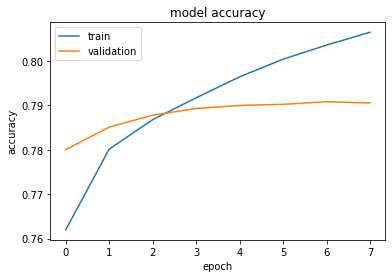

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

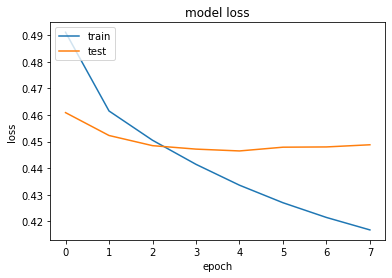

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

29599/29599 [==============================] - 2129s 72ms/step
Accuracy: 79.07%


In [ ]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef


In [ ]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [ ]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [ ]:
data_train1 = data_r[0:79999]
labels_train1 = data.Sentiment[0:79999]

data_test1  = data_r[80000:159999]
labels_test1  = data.Sentiment[80000:159999]



In [ ]:
# Logistic Model
logreg = LogReg(LEARNING_RATE, 20, len(data_train1[0]))
bias_logreg, weights_logreg = logreg.train(data_train1, labels_train1)

In [ ]:
y_logistic = [round(logreg.predict(example)) for example in data_test1]

In [ ]:
# Compare accuracies
accuracy_logistic = get_accuracy(y_logistic, labels_test1)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))


Logistic Regression Accuracy: 55.633


In [ ]:
import pickle
with open('model', 'wb') as picklefile:
    pickle.dump(model,picklefile)

In [ ]:
import pickle
with open('tokenizer', 'wb') as picklefile:
    pickle.dump(tokenizer,picklefile)